In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os, glob
import tensorflow as tf
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [13]:
data_dir="C:\\Users\\Gowtham kumar\\OneDrive\\Desktop\\CODE\\PAVAN_plant_leaf_disease\\data"


In [14]:
Plants=[]
for file in os.listdir(data_dir):
    Plants+=[file]
print(Plants)
print(len(Plants))

['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Tomato___Bacterial_spot', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']
11


In [18]:
train_dir = os.path.join(data_dir)

train_data = []
for defects_id, sp in enumerate(Plants):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])

train = pd.DataFrame(train_data, columns=['File', 'LabelID', 'Label'])
train.head()

,File,LabelID,Label
0,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,0,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...
1,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,0,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...
2,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,0,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...
3,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,0,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...
4,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,0,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...


In [19]:
SEED = 42
train = train.sample(frac=1, random_state=SEED)
train.index = np.arange(len(train))  # Reset indices
train.tail()

,File,LabelID,Label
5109,Tomato___Late_blight/7ee00267-be66-4b6a-a207-0...,9,Tomato___Late_blight
5110,Corn_(maize)___Common_rust_/img (15).JPG,1,Corn_(maize)___Common_rust_
5111,Potato___Late_blight/bd70c718-5846-42a1-8b05-2...,6,Potato___Late_blight
5112,Tomato___healthy/img (182).JPG,8,Tomato___healthy
5113,Corn_(maize)___Common_rust_/img (75).JPG,1,Corn_(maize)___Common_rust_


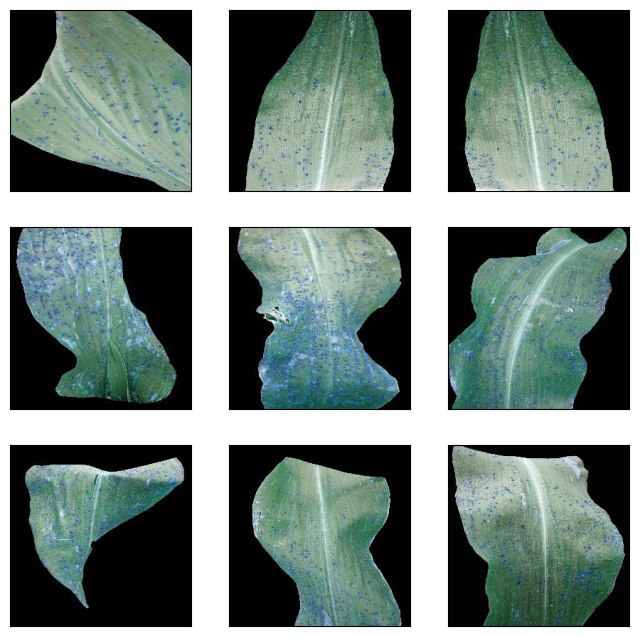

In [21]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(8, 8))
    defect_files = train['File'][train['Label'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1


plot_defects('Corn_(maize)___Common_rust_', 3, 3)

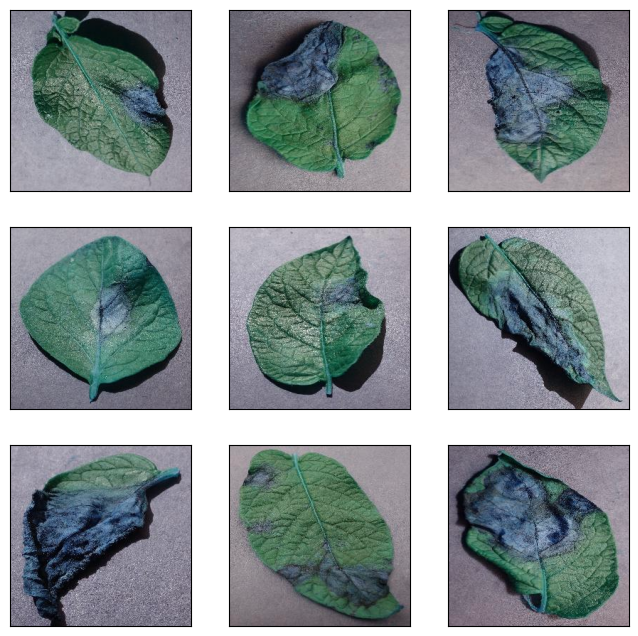

In [22]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(8, 8))
    defect_files = train['File'][train['Label'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1


plot_defects('Potato___Late_blight', 3, 3)

In [23]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split = 0.2)


train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    class_mode='categorical')

Found 5114 images belonging to 11 classes.


In [24]:
IMAGE_SIZE = 128


def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath))


def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [25]:
x_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        x_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))


x_train = x_train / 255.

num_classes=11
y_train = train['LabelID'].values
y_train = to_categorical(y_train,num_classes)

X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=SEED)
print('Train Shape: {}'.format(X_train.shape))
print('Train Shape: {}'.format(Y_train.shape))

5114it [00:05, 946.33it/s] 


Train Shape: (3579, 128, 128, 3)
Train Shape: (3579, 11)


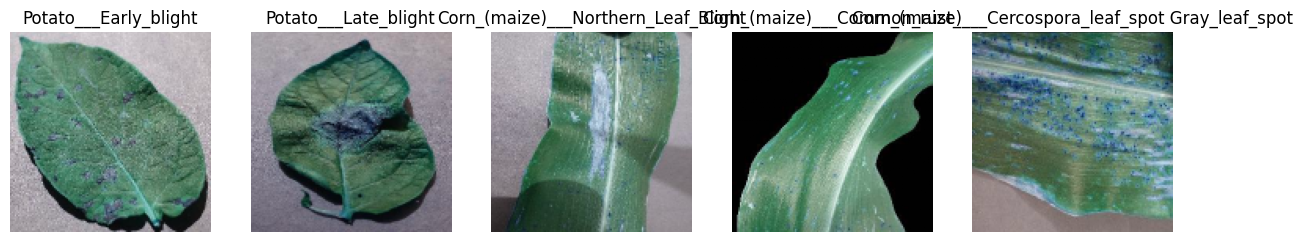

In [26]:
fig, ax = plt.subplots(1, 5, figsize=(15, 15))
for i in range(5):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(Plants[np.argmax(Y_train[i])])

In [27]:
from tensorflow.keras.regularizers import l2

In [28]:
model = Sequential()
model.add(Conv2D(filters = 32, padding = "same",activation = "relu",kernel_size=3, strides = 2,input_shape=(128,128,3)))
model.add(MaxPool2D(pool_size=(2,2),strides = 2))

model.add(Conv2D(filters = 32, padding = "same",activation = "relu",kernel_size=3))
model.add(MaxPool2D(pool_size=(2,2),strides = 2))

model.add(Flatten())
model.add(Dense(128,activation="relu"))


model.add(Dense(num_classes,kernel_regularizer=l2(0.01),activation = "softmax"))
model.summary()

c:\Users\Gowtham kumar\OneDrive\Desktop\CODE\PAVAN_plant_leaf_disease\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,060,267 (4.04 MB)

 Trainable params: 1,060,267 (4.04 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model.compile(optimizer="adam",loss="squared_hinge", metrics = ['accuracy'])
hist = model.fit(X_train,Y_train,epochs=50,batch_size=10,validation_data=(X_test,Y_test))

Epoch 1/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.3343 - loss: 1.1968 - val_accuracy: 0.6899 - val_loss: 1.0377
Epoch 2/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.7023 - loss: 1.0264 - val_accuracy: 0.7179 - val_loss: 1.0169
Epoch 3/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.7669 - loss: 1.0008 - val_accuracy: 0.7739 - val_loss: 1.0018
Epoch 4/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.8331 - loss: 0.9800 - val_accuracy: 0.8235 - val_loss: 0.9810
Epoch 5/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8728 - loss: 0.9663 - val_accuracy: 0.8606 - val_loss: 0.9678
Epoch 6/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.8828 - loss: 0.9597 - val_accuracy: 0.8502 - val_loss: 0.9701
Epoch 7/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.9133 - loss: 0.9482 - val_accuracy: 0.8710 - val_loss: 0.9622
Epoch 8/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.9239 - loss: 0.9460 - val_acc

In [33]:
model.evaluate(X_test, Y_test)
model.save("C:\\Users\\Gowtham kumar\\OneDrive\\Desktop\\CODE\\PAVAN_plant_leaf_disease\\models\\SVC.h5")

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8767 - loss: 0.9537


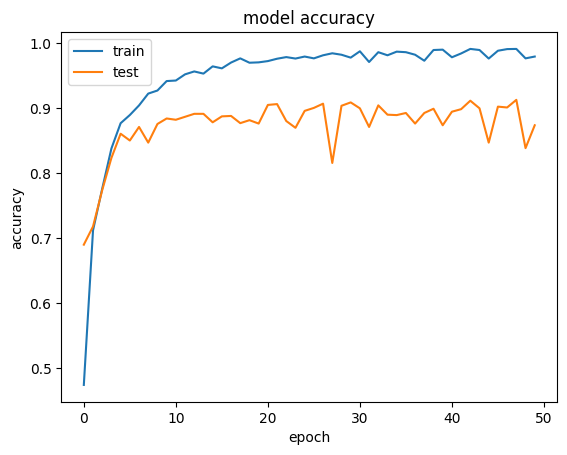

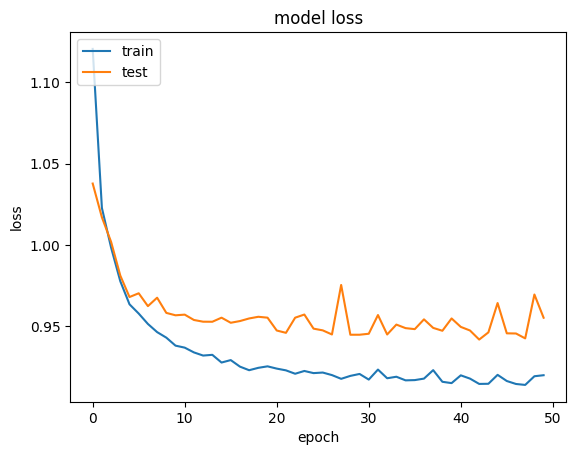

In [34]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [35]:
from tensorflow import keras

In [36]:
model1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [128, 128,3]),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dense(32, activation = 'relu'),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

model1.summary()

c:\Users\Gowtham kumar\OneDrive\Desktop\CODE\PAVAN_plant_leaf_disease\venv\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     6,291,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 11)             │           363 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,302,283 (24.04 MB)

 Trainable params: 6,302,283 (24.04 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
model1.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])
hist1=model1.fit(X_train,Y_train,epochs=50,batch_size=5,validation_data=(X_test,Y_test))

Epoch 1/50
716/716 ━━━━━━━━━━━━━━━━━━━━ 44s 59ms/step - accuracy: 0.1618 - loss: 3.7952 - val_accuracy: 0.2671 - val_loss: 2.1271
Epoch 2/50
716/716 ━━━━━━━━━━━━━━━━━━━━ 49s 68ms/step - accuracy: 0.2209 - loss: 2.1532 - val_accuracy: 0.1961 - val_loss: 2.1207
Epoch 3/50
716/716 ━━━━━━━━━━━━━━━━━━━━ 47s 66ms/step - accuracy: 0.2418 - loss: 2.0901 - val_accuracy: 0.2840 - val_loss: 1.9434
Epoch 4/50
716/716 ━━━━━━━━━━━━━━━━━━━━ 43s 59ms/step - accuracy: 0.3035 - loss: 1.9149 - val_accuracy: 0.3303 - val_loss: 1.7719
Epoch 5/50
716/716 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - accuracy: 0.3241 - loss: 1.8029 - val_accuracy: 0.3629 - val_loss: 1.6726
Epoch 6/50
716/716 ━━━━━━━━━━━━━━━━━━━━ 44s 61ms/step - accuracy: 0.3423 - loss: 1.7490 - val_accuracy: 0.3479 - val_loss: 1.6737
Epoch 7/50
716/716 ━━━━━━━━━━━━━━━━━━━━ 43s 60ms/step - accuracy: 0.3610 - loss: 1.6569 - val_accuracy: 0.3818 - val_loss: 1.5937
Epoch 8/50
716/716 ━━━━━━━━━━━━━━━━━━━━ 42s 58ms/step - accuracy: 0.3485 - loss: 1.7326 - 

In [38]:
model1.evaluate(X_test, Y_test)
model1.save("C:\\Users\\Gowtham kumar\\OneDrive\\Desktop\\CODE\\PAVAN_plant_leaf_disease\\models\\ANN.h5")

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6417 - loss: 1.0067


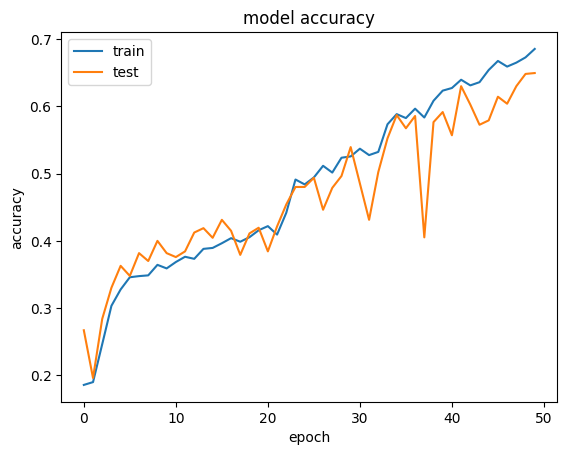

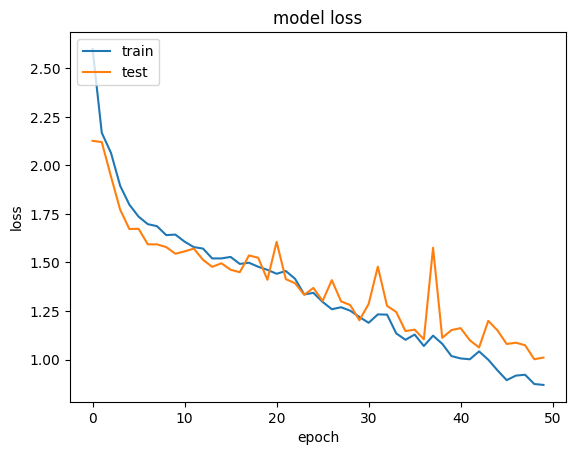

In [40]:
plt.plot(hist1.history['accuracy'])
plt.plot(hist1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [41]:
model2 = Sequential()

model2.add(Conv2D(128, kernel_size=(3,3),activation='relu',input_shape=(128,128,3)))
model2.add(Conv2D(64, kernel_size=(3,3),activation='relu'))
model2.add(Conv2D(32, kernel_size=(3,3),activation='relu'))
model2.add(Flatten())
model2.add(Dense(num_classes, activation='softmax'))

model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 124, 124, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 122, 122, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 476288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 11)             │     5,239,179 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,335,019 (20.35 MB)

 Trainable params: 5,335,019 (20.35 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
model2.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])
hist2=model2.fit(X_train,Y_train,epochs=5,batch_size=10,validation_data=(X_test,Y_test))

Epoch 1/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 249s 692ms/step - accuracy: 0.2586 - loss: 2.4383 - val_accuracy: 0.5029 - val_loss: 1.6779
Epoch 2/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 248s 693ms/step - accuracy: 0.5920 - loss: 1.3191 - val_accuracy: 0.5153 - val_loss: 1.5449
Epoch 3/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 232s 647ms/step - accuracy: 0.7698 - loss: 0.7122 - val_accuracy: 0.5557 - val_loss: 2.0674
Epoch 4/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 231s 645ms/step - accuracy: 0.9164 - loss: 0.2743 - val_accuracy: 0.5909 - val_loss: 2.0107
Epoch 5/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 230s 641ms/step - accuracy: 0.9730 - loss: 0.1435 - val_accuracy: 0.5746 - val_loss: 3.0416


In [43]:
model2.evaluate(X_test, Y_test)
model2.save("C:\\Users\\Gowtham kumar\\OneDrive\\Desktop\\CODE\\PAVAN_plant_leaf_disease\\models\\CNN.h5")

48/48 ━━━━━━━━━━━━━━━━━━━━ 24s 492ms/step - accuracy: 0.5517 - loss: 3.2859


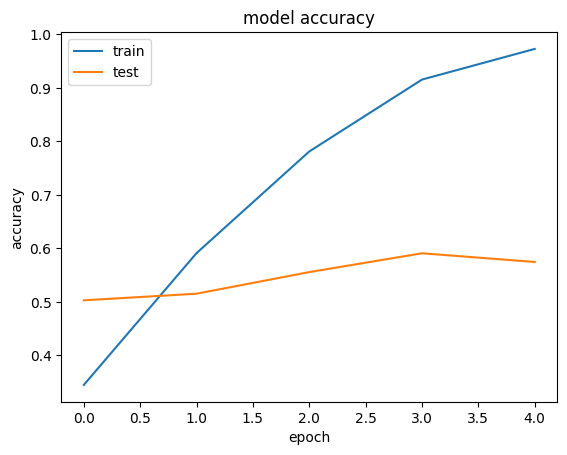

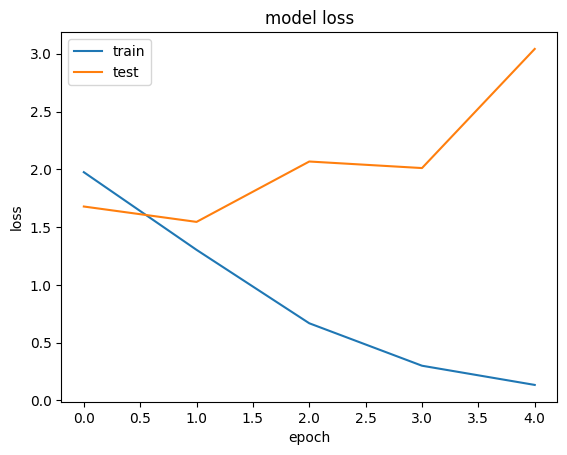

In [44]:
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [45]:
base_model3 = tf.keras.applications.ResNet50(input_shape=(128, 128, 3), include_top=False,
                          weights='imagenet')
model3 = Sequential()
model3.add(base_model3)
model3.add(GlobalAveragePooling2D())
model3.add(Dense(64, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.2))
model3.add(Dense(num_classes, activation='sigmoid'))
model3.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,719,819 (90.48 MB)

 Trainable params: 23,666,571 (90.28 MB)

 Non-trainable params: 53,248 (208.00 KB)

In [46]:
model3.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])
hist3=model3.fit(X_train,Y_train,epochs=5,batch_size=10,validation_data=(X_test,Y_test))

Epoch 1/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 512s 1s/step - accuracy: 0.5696 - loss: 1.4029 - val_accuracy: 0.0873 - val_loss: 3.4464
Epoch 2/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 477s 1s/step - accuracy: 0.8224 - loss: 0.5808 - val_accuracy: 0.0977 - val_loss: 4.5458
Epoch 3/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 482s 1s/step - accuracy: 0.9125 - loss: 0.2827 - val_accuracy: 0.6476 - val_loss: 1.0738
Epoch 4/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 481s 1s/step - accuracy: 0.9269 - loss: 0.2440 - val_accuracy: 0.7101 - val_loss: 0.8278
Epoch 5/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 466s 1s/step - accuracy: 0.9368 - loss: 0.2066 - val_accuracy: 0.8091 - val_loss: 0.6420


In [47]:
model3.evaluate(X_test, Y_test)
model3.save("C:\\Users\\Gowtham kumar\\OneDrive\\Desktop\\CODE\\PAVAN_plant_leaf_disease\\models\\ResNet50.h5")

48/48 ━━━━━━━━━━━━━━━━━━━━ 31s 638ms/step - accuracy: 0.8165 - loss: 0.6198


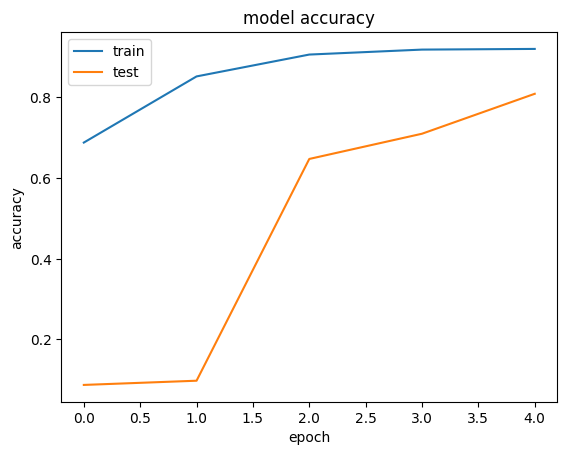

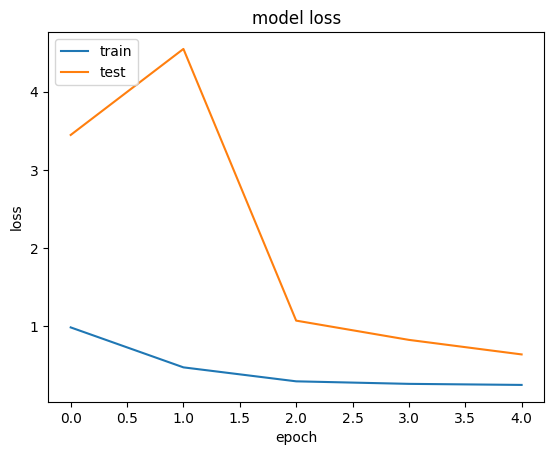

In [48]:
plt.plot(hist3.history['accuracy'])
plt.plot(hist3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [49]:
Accuracy = []

for i in [hist, hist1, hist2,hist3]:
    x = i.history.get('accuracy')[-1]
    Accuracy.append(x)

Accuracy

[0.9793238043785095, 0.6853869557380676, 0.972897469997406, 0.9203687906265259]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
[3.1658358e-06 2.9479848e-05 3.5388657e-23 3.5098542e-11 3.5486536e-04
 2.2060831e-01 3.7056826e-02 4.7336820e-01 2.3442564e-05 2.4474584e-01
 2.3809813e-02]


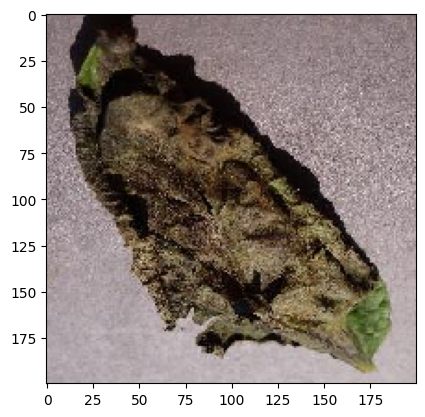

Prediction: Tomato___Bacterial_spot


In [57]:
from skimage import io
from keras.preprocessing import image
from keras.preprocessing import image

img = image.load_img(
    r'C:\Users\Gowtham kumar\OneDrive\Desktop\CODE\PAVAN_plant_leaf_disease\data\Potato___Late_blight\8b0ef54c-6d28-47bb-a657-287afbb8a620___RS_LB 3298.JPG',
    color_mode='rgb',  # Use 'grayscale' or 'rgb'
    target_size=(128, 128)
)

show_img = image.load_img(
    r'C:\Users\Gowtham kumar\OneDrive\Desktop\CODE\PAVAN_plant_leaf_disease\data\Potato___Late_blight\8b0ef54c-6d28-47bb-a657-287afbb8a620___RS_LB 3298.JPG',
    color_mode='rgb',
    target_size=(200, 200)
)
Plants = ['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Tomato___Bacterial_spot', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model1.predict(x)
print(custom[0])


plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',Plants[ind])